**Instalación**

In [ ]:
!pip install imbalanced-learn matplotlib seaborn pandas numpy scikit-learn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 147.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 136.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 151.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: matplotlib
    Found exis

**Importaciones**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE # es para el SMOTE

**Configuración**

In [2]:
#Configuración visual
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

#Directorio de salida
OUTPUT_DIR = 'outputs_lr'
os.makedirs(OUTPUT_DIR, exist_ok=True)

#semilla para reproducibilidad
RANDOM_STATE = 42

#definición de la variable objetivo
TARGET_VARIABLE = 'ESTADO_PROGRAMA'

#ruta del dataset original
DATA_FILE = '/content/drive/MyDrive/Estudios/UNIR/04. Máster en IA/07. TFE/DATA/data_regresion_logistica/dataset_estudiantes_desercion_regresion_logistica.csv'


#configuración del modelo logístico Multinomial
LOGISTIC_CONFIG = {
    'solver': 'lbfgs',             #motor estándar para multiclase
    'multi_class': 'multinomial',  #para activar Softmax
    'max_iter': 3000,
    'class_weight': 'balanced',    #balancear los pesos
    'random_state': RANDOM_STATE,
    'n_jobs': -1                   #usar toda la CPU
}

print(f"Configuración Logística Multiclase")
print(f"Objetivo: {TARGET_VARIABLE}")
print(f"Modo: multinomial (Softmax)")

Configuración Logística Multiclase
Objetivo: ESTADO_PROGRAMA
Modo: multinomial (Softmax)


**Carga y Preprocesamiento (Optimizado)**

In [3]:
#carga del dataset
df = pd.read_csv(DATA_FILE, sep=';', encoding='latin-1', low_memory=False)

#columnas que se van a excluir
COLUMNAS_EXCLUIR = [
    'TIPO_DOCUMENTO', 'COHORTE', 'PERIODO_ACADEMICO', 'FRANJA', 'ESTADO_ESTUDIANTE_PERIODO',
    'ID_ESTUDIANTE', 'DOCUMENTO', 'CODPROG_MATRICULA', 'PROGRAMA_COD'
]

#varibales objetivo
otras_targets = ['ESTADO_PROGRAMA', 'ESTADO_IES', 'ESTADO_SISTEMA', 'GRUPO_RIESGO']

COLUMNAS_EXCLUIR.extend([t for t in otras_targets if t != TARGET_VARIABLE])

columnas_disponibles = [col for col in df.columns if col not in COLUMNAS_EXCLUIR]
df_clean = df[columnas_disponibles].copy()


#Limpieza de la variable objetivo
#primero se convierte a NaN
valores_nulos = ['SIN INFORMACIÓN', 'SIN_INFO', 'nan', 'NaN', 'No aplica', 'NO APLICA']
df_clean.replace(valores_nulos, np.nan, inplace=True)
#proceso para eliminar las filas donde el objetivo sea nulo
df_clean = df_clean[df_clean[TARGET_VARIABLE].notna()]

#codificación de la variable objetivo multiclase
le = LabelEncoder()
df_clean['TARGET'] = le.fit_transform(df_clean[TARGET_VARIABLE])

#awquí mostramos el diccionario para saber qué es cada número
print(f"Clases encontradas: {len(le.classes_)}")
print(f"Mapeo de clases: {dict(zip(le.classes_, le.transform(le.classes_)))}")

#en esta parte eliminamos la columna de texto original
if TARGET_VARIABLE in df_clean.columns:
    df_clean.drop(columns=[TARGET_VARIABLE], inplace=True)

#proceso de imputación de valores
y = df_clean['TARGET']
X_temp = df_clean.drop(columns=['TARGET'])

num_cols = X_temp.select_dtypes(include=[np.number]).columns
cat_cols = X_temp.select_dtypes(include=['object']).columns

for col in num_cols:
    if X_temp[col].isnull().any():
        X_temp[col] = X_temp[col].fillna(X_temp[col].median())

for col in cat_cols:
    if X_temp[col].isnull().any():
        moda = X_temp[col].mode()
        val = moda[0] if len(moda) > 0 else 'DESCONOCIDO'
        X_temp[col] = X_temp[col].fillna(val)

#proceso de One-Hot Encoding
MAX_CATEGORIAS = 15
cols_codificar = [c for c in cat_cols if X_temp[c].nunique() <= MAX_CATEGORIAS]

print(f"Codificando {len(cols_codificar)} variables categóricas (drop='first')")
X = pd.get_dummies(X_temp, columns=cols_codificar, drop_first=True, dtype=int)
X = X.select_dtypes(exclude=['object'])

#asegurar alineación
y = y.loc[X.index]

#proceso de conversión a float32 y escalado
X = X.astype('float32')
scaler = StandardScaler()
X[:] = scaler.fit_transform(X)

feature_names = X.columns.tolist()
print(f"Preprocesamiento listo.")
print(f"Matriz final: {X.shape}")

Clases encontradas: 3
Mapeo de clases: {'Ausente': np.int64(0), 'Desertor': np.int64(1), 'Graduado': np.int64(2)}
Codificando 58 variables categóricas (drop='first')
Preprocesamiento listo.
Matriz final: (824786, 233)


**División y SMOTE**

In [4]:
#proceso de fragmentación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print(f"Train original: {X_train.shape[0]:,} muestras")

#aplicacion de SMOTE
print("Aplicando SMOTE para generar datos sintéticos")

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=4)

try:
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print(f"Balanceo completado.")
    print(f"Train balanceado: {X_train_bal.shape[0]:,} muestras")

    conteo = y_train_bal.value_counts().sort_index()
    nombres = le.inverse_transform(conteo.index)
    distribucion = dict(zip(nombres, conteo.values))

    print(f"Distribución final: {distribucion}")

except ValueError as e:
    print(f"ADVERTENCIA: {e}")
    print("Probablemente una clase tiene menos de 4 muestras. Se usará el dataset original.")
    print("La Regresión Logística usará 'class_weight=balanced' para compensar.")
    X_train_bal, y_train_bal = X_train, y_train
except Exception as e:
    print(f"Error inesperado: {e}. Usando datos originales.")
    X_train_bal, y_train_bal = X_train, y_train

Train original: 659,828 muestras
Aplicando SMOTE para generar datos sintéticos
Balanceo completado.
Train balanceado: 802,044 muestras
Distribución final: {'Ausente': np.int64(267348), 'Desertor': np.int64(267348), 'Graduado': np.int64(267348)}


**Entrenamiento y Validación Cruzada**

In [5]:
#Instanciar el modelo
lr_model = LogisticRegression(**LOGISTIC_CONFIG)

#proceso de Validación Cruzada
print("Ejecutando validación cruzada (10-fold)")
cv_scores = cross_val_score(lr_model, X_train_bal, y_train_bal, cv=10, scoring='f1_macro', n_jobs=-1)

print(f"F1-Score Macro promedio en validación cruzada: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

#Entrenamiento Final
print("Entrenando modelo final")
lr_model.fit(X_train_bal, y_train_bal)
print("Modelo entrenado")

#confirmar si convergió antes del límite
print(f"Iteraciones necesarias para converger: {lr_model.n_iter_}")

Ejecutando validación cruzada (10-fold)
F1-Score Macro promedio en validación cruzada: 0.7870 (+/- 0.0026)
Entrenando modelo final
Modelo entrenado
Iteraciones necesarias para converger: [72]


**Evaluación y Gráficos**


RESULTADOS MULTICLASE PARA: ESTADO_PROGRAMA
--------------------------------------------------
Accuracy Global:   0.7886
Macro Recall:      0.7810
Macro F1-Score:    0.7717
Macro AUC-ROC:     0.9252
--------------------------------------------------

--- Reporte detallado por Clase ---
              precision    recall  f1-score   support

     Ausente       0.81      0.74      0.77     61928
    Desertor       0.54      0.75      0.63     36192
    Graduado       0.99      0.86      0.92     66838

    accuracy                           0.79    164958
   macro avg       0.78      0.78      0.77    164958
weighted avg       0.82      0.79      0.80    164958



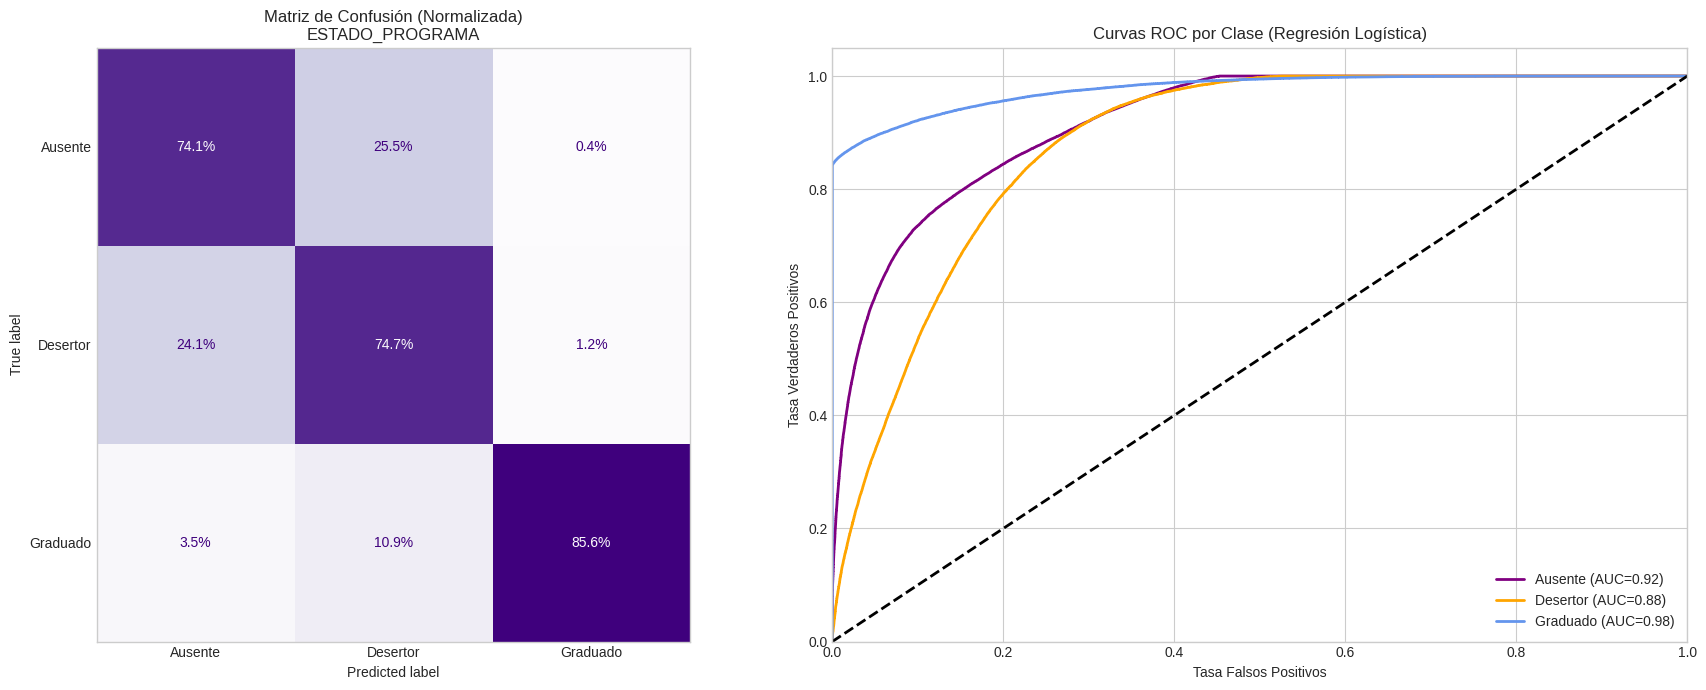

In [7]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

#Predicciones
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)

#Métricas, en este caso se usa 'macro' para dar igual peso a todas las clases incluida la minoritaria 'Ausente'
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

#AUC Multiclase
try:
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
except ValueError:
    print("No se pudo calcular AUC (posiblemente falta una clase en el test set).")
    auc = 0.5
print()
print(f"RESULTADOS MULTICLASE PARA: {TARGET_VARIABLE}")
print("-" * 50)
print(f"Accuracy Global:   {acc:.4f}")
print(f"Macro Recall:      {rec:.4f}")
print(f"Macro F1-Score:    {f1:.4f}")
print(f"Macro AUC-ROC:     {auc:.4f}")
print("-" * 50)
print()

#Reporte de texto
nombres_clases = [str(c) for c in le.classes_]
print("--- Reporte detallado por Clase ---")
print(classification_report(y_test, y_pred, target_names=nombres_clases))

#Gráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

#Gráfico de Matriz de Confusión normalizada
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=nombres_clases,
    cmap='Purples',
    normalize='true', #para ver porcentajes
    values_format=".1%",
    ax=axes[0],
    colorbar=False
)
axes[0].set_title(f'Matriz de Confusión (Normalizada)\n{TARGET_VARIABLE}')
axes[0].grid(False)

#Gráfico de Curvas ROC (One-vs-Rest)
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))
colors = cycle(['purple', 'orange', 'cornflowerblue', 'green', 'red'])

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])

    class_name = nombres_clases[i]
    axes[1].plot(
        fpr, tpr,
        color=color,
        lw=2,
        label=f'{class_name} (AUC={roc_auc:.2f})'
    )

axes[1].plot([0, 1], [0, 1], 'k--', lw=2) #línea de azar
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa Falsos Positivos')
axes[1].set_ylabel('Tasa Verdaderos Positivos')
axes[1].set_title('Curvas ROC por Clase (Regresión Logística)')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

**Interpretabilidad (Coeficientes y Odds Ratios)**

Analizando coeficientes para la clase: 'Desertor' (Índice 1)

Top 20 variables que influyen en: DESERTOR


,Variable,Odds Ratio,Interpretación
32,NIVEL_SISBEN_1.0,2.969848,Aumenta el riesgo de Desertor en x2.97
21,ESTRATO_1.0,2.405041,Aumenta el riesgo de Desertor en x2.41
41,APOYO_FINANCIERO_SÃ,2.231998,Aumenta el riesgo de Desertor en x2.23
183,¿Cuál es el tipo de vinculación al Sistema Gen...,0.599388,Protector: Reduce el riesgo en 40.1%
182,¿Cuál es el tipo de vinculación al Sistema Gen...,0.602689,Protector: Reduce el riesgo en 39.7%
23,ESTRATO_2.0,1.611119,Aumenta el riesgo de Desertor en x1.61
180,¿Cuál es el tipo de vinculación al Sistema Gen...,0.781177,Protector: Reduce el riesgo en 21.9%
39,NIVEL_SISBEN_5.0,1.267559,Aumenta el riesgo de Desertor en x1.27
62,Desde su graduación como bachiller usted_Estud...,1.248780,Aumenta el riesgo de Desertor en x1.25
0,SEMESTRE_EST,0.838540,Protector: Reduce el riesgo en 16.1%


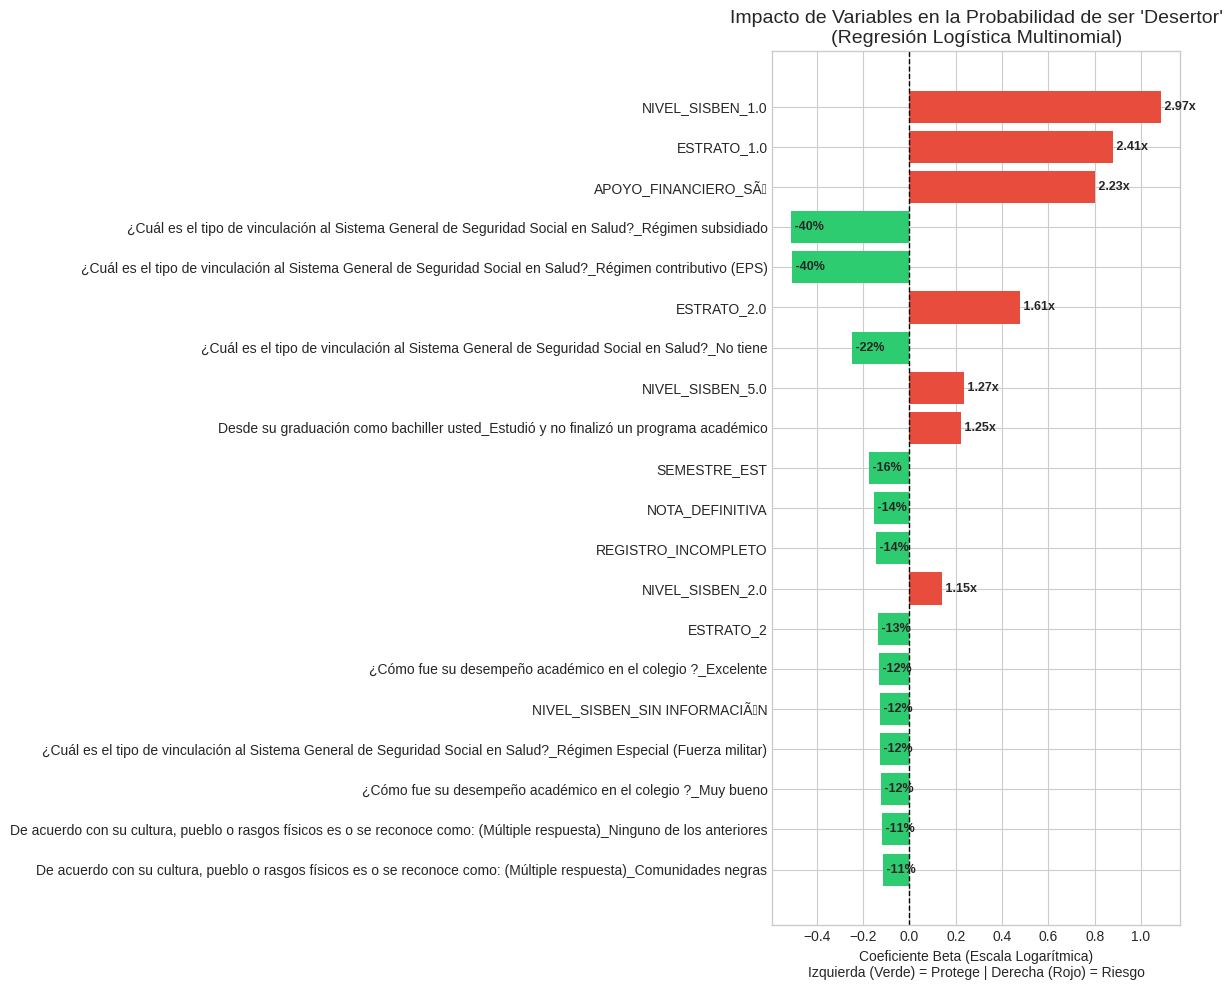

In [8]:
#identificar el índice de la clase "Desertor"
target_name = 'Desertor'

if target_name in le.classes_:
    idx_target = list(le.classes_).index(target_name)
    print(f"Analizando coeficientes para la clase: '{target_name}' (Índice {idx_target})")

    #extracción de coeficientes solo de esa clase objetivo
    coefs = lr_model.coef_[idx_target]
else:
    print(f"No se encontró la clase '{target_name}'. Analizando la última clase por defecto.")
    coefs = lr_model.coef_[-1]

#proceso para calcular Odds Ratios
odds_ratios = np.exp(coefs)

#crear DataFrame
df_coefs = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente (Beta)': coefs,
    'Odds Ratio': odds_ratios,
    'Impacto Absoluto': np.abs(coefs)
})

#ordenar por impacto (Top 20)
df_coefs = df_coefs.sort_values('Impacto Absoluto', ascending=False).head(20)

#Función de interpretación verbal
def interpretar(row):
    if row['Odds Ratio'] > 1:
        return f"Aumenta el riesgo de {target_name} en x{row['Odds Ratio']:.2f}"
    else:
        return f"Protector: Reduce el riesgo en {(1-row['Odds Ratio'])*100:.1f}%"

df_coefs['Interpretación'] = df_coefs.apply(interpretar, axis=1)

#mostrar tabla
print(f"\nTop 20 variables que influyen en: {target_name.upper()}")
try:
    display(df_coefs[['Variable', 'Odds Ratio', 'Interpretación']])
except:
    print(df_coefs[['Variable', 'Odds Ratio', 'Interpretación']])

#Gráfico de coeficientes
plt.figure(figsize=(12, 10))

#rojo si aumenta el riesgo de deserción, verde si protege o baja el riesgo
colors = ['#e74c3c' if c > 0 else '#2ecc71' for c in df_coefs['Coeficiente (Beta)']]

plt.barh(df_coefs['Variable'], df_coefs['Coeficiente (Beta)'], color=colors)
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.title(f"Impacto de Variables en la Probabilidad de ser '{target_name}'\n(Regresión Logística Multinomial)", fontsize=14)
plt.xlabel("Coeficiente Beta (Escala Logarítmica)\nIzquierda (Verde) = Protege | Derecha (Rojo) = Riesgo")
plt.gca().invert_yaxis()

for index, value in enumerate(df_coefs['Coeficiente (Beta)']):
    label = f"{np.exp(value):.2f}x" if value > 0 else f"-{(1-np.exp(value))*100:.0f}%"
    plt.text(value, index, f" {label}", va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()